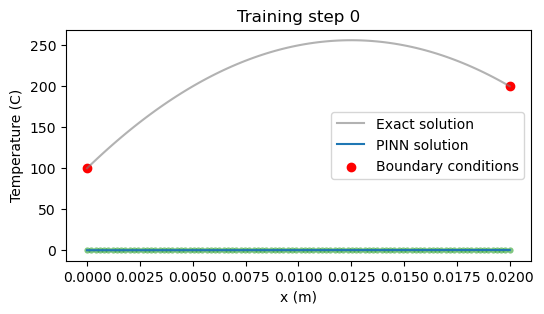

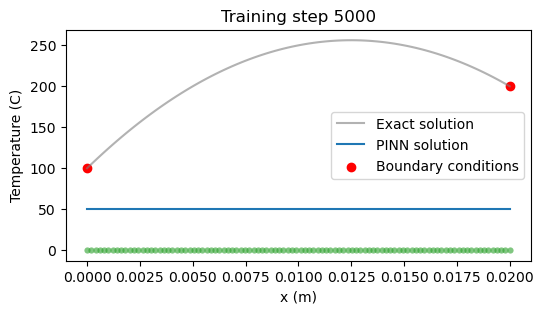

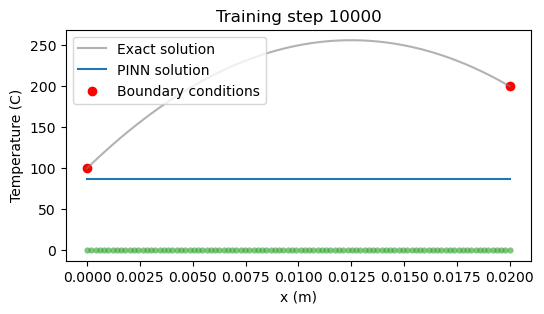

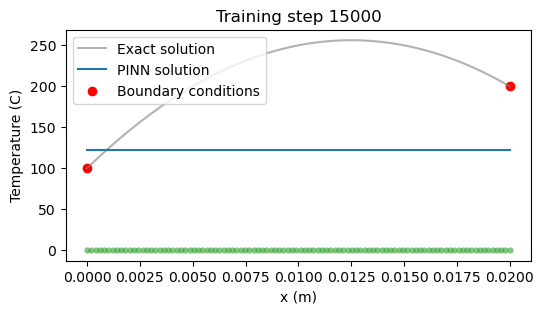

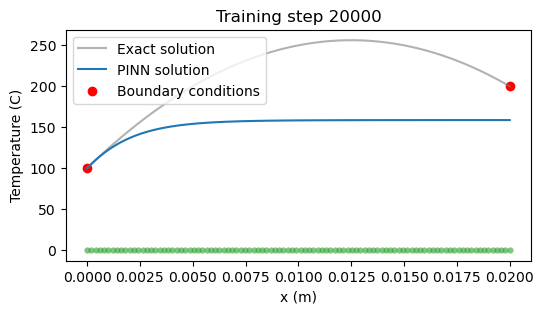

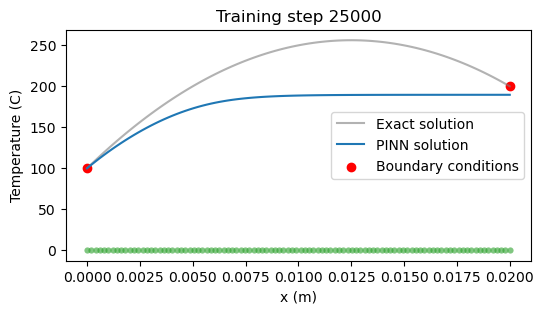

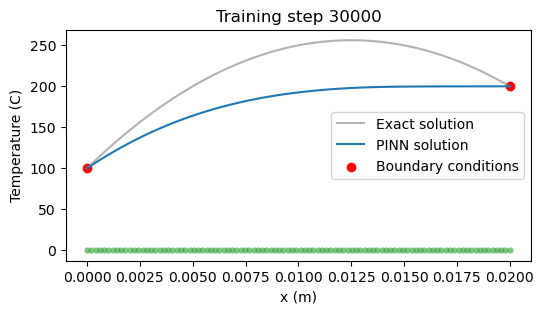

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Parameters
k = 0.5  # Thermal conductivity in W/m.K
q = 1e6  # Heat generation in W/m^3
L = 0.02  # Thickness of the plate in m
T_A, T_B = 100, 200  # Boundary temperatures at x = 0 and x = L

# Analytical solution for comparison
def exact_temperature(x_norm):
    x_physical = x_norm * L
    return -q / (2 * k) * x_physical**2 + ((T_B - T_A) / L + q * L / (2 * k)) * x_physical + T_A

# Define the neural network
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(*[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

torch.manual_seed(123)
pinn = FCN(1, 1, 80, 4) 

# Boundary points and collocation points for physics loss
x_boundary_A = torch.tensor([0.0], requires_grad=True).view(-1, 1)
x_boundary_B = torch.tensor([1.0], requires_grad=True).view(-1, 1)
x_physics = torch.linspace(0, 1, 100, requires_grad=True).view(-1, 1)  

# Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)

# Training loop
lambda1, lambda2 = 1.0, 1e-12  

for i in range(30001):
    optimizer.zero_grad()

    # Boundary condition loss
    T_A_pred = pinn(x_boundary_A)
    T_B_pred = pinn(x_boundary_B)
    loss_boundary = (T_A_pred - T_A)**2 + (T_B_pred - T_B)**2

    # Physics loss (governing equation)
    T_pred = pinn(x_physics)
    dT_dx = torch.autograd.grad(T_pred, x_physics, torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_physics, torch.ones_like(dT_dx), create_graph=True)[0]
    
    # Normalized coordinates
    d2T_dx2_physical = d2T_dx2 / (L**2)
    loss_physics = torch.mean((k * d2T_dx2_physical + q)**2)

    # Total loss
    loss = lambda1 * loss_boundary + lambda2 * loss_physics
    loss.backward()
    optimizer.step()
    scheduler.step(loss)

    if i % 5000 == 0:
        x_test = torch.linspace(0, 1.0, 100).view(-1, 1)
        T_exact = exact_temperature(x_test.numpy())
        T_pinn = pinn(x_test).detach().numpy()

        plt.figure(figsize=(6, 3))
        plt.plot(x_test * L, T_exact, label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(x_test * L, T_pinn, label="PINN solution", color="tab:blue")
        plt.scatter(x_physics.detach() * L, torch.zeros_like(x_physics), s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter([0, L], [T_A, T_B], color="red", label="Boundary conditions")
        plt.title(f"Training step {i}")
        plt.xlabel("x (m)")
        plt.ylabel("Temperature (C)")
        plt.legend()
        plt.show()

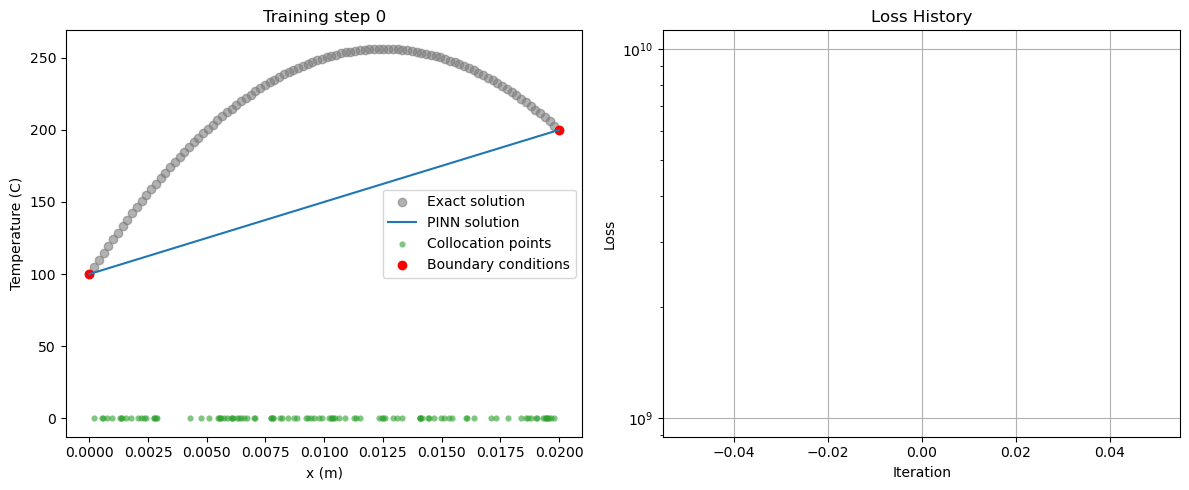

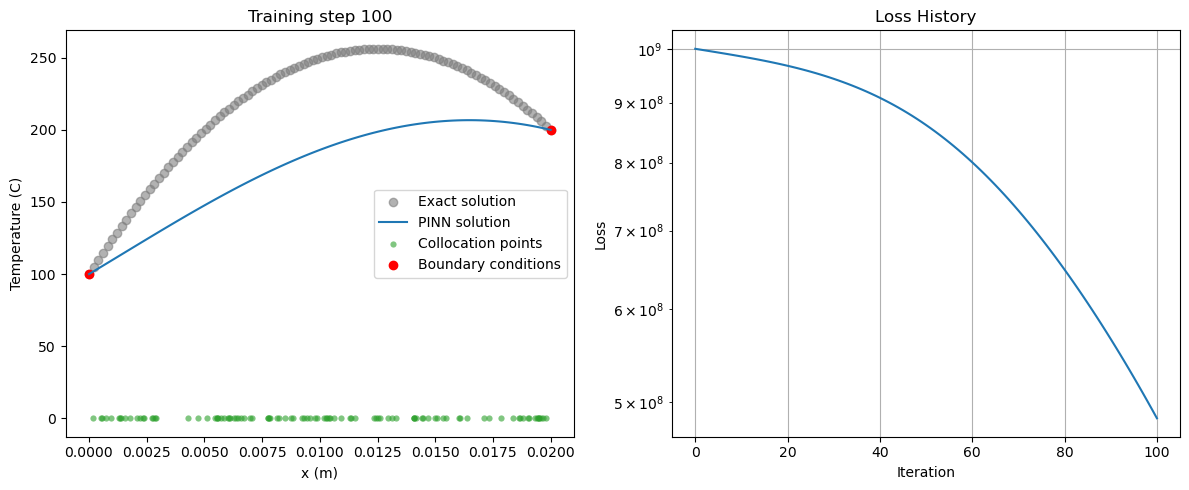

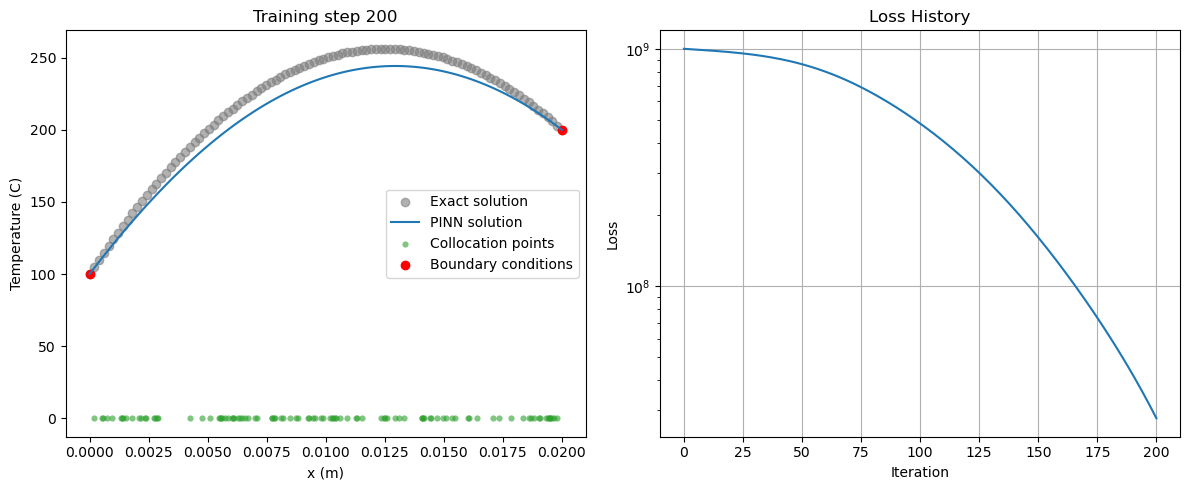

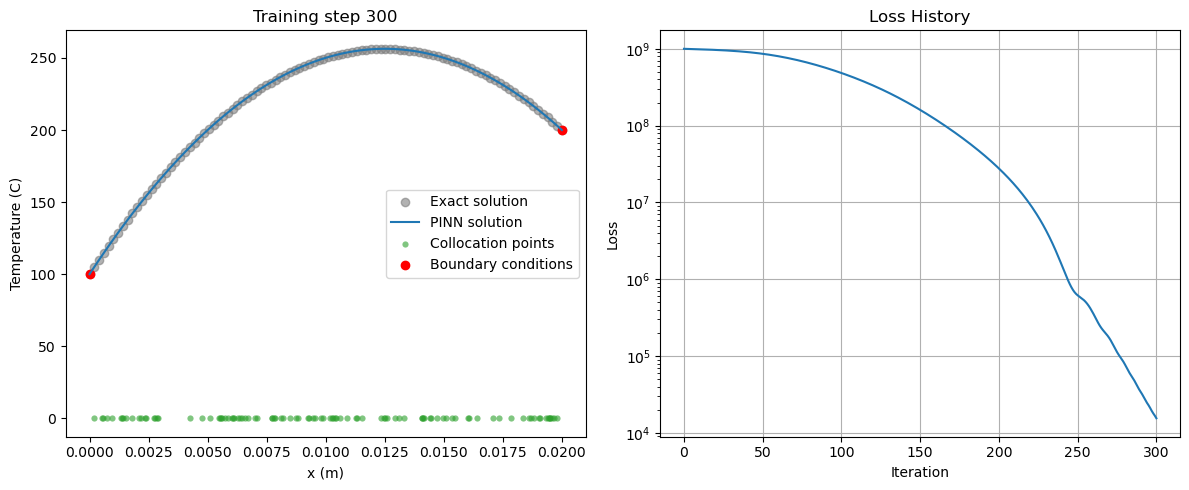

In [2]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_tensor_type(torch.FloatTensor)

# Parameters
k = 0.5  # Thermal conductivity in W/m.K
q = 1e6  # Heat generation in W/m^3
L = 0.02  # Thickness of the plate in m
T_A = torch.tensor(100.0, dtype=torch.float32)
T_B = torch.tensor(200.0, dtype=torch.float32) 

# Analytical solution for comparison
def exact_temperature(x_norm):
    x_physical = x_norm * L
    return -q / (2 * k) * x_physical**2 + ((T_B.item() - T_A.item()) / L + q * L / (2 * k)) * x_physical + T_A.item()

# Define the neural network
class StableFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
    
        x = x.to(torch.float32)
        base_solution = T_A + x * (T_B - T_A)  
        residual = self.network(x)

        scaled_residual = residual * 0.5 * (T_B - T_A) * (1 - x) * x
        return base_solution + scaled_residual

torch.manual_seed(123)
pinn = StableFCN()

# Training points
x_boundary_A = torch.tensor([[0.0]], requires_grad=True, dtype=torch.float32)
x_boundary_B = torch.tensor([[1.0]], requires_grad=True, dtype=torch.float32)

# Collocation points 
n_points = 100
x_physics = torch.tensor(np.random.uniform(0, 1, (n_points, 1)), 
                        requires_grad=True, 
                        dtype=torch.float32)

optimizer = torch.optim.AdamW(pinn.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.8, patience=1000, verbose=True, min_lr=1e-6
)

lambda1, lambda2 = 1.0, 1e-3 

losses = []
for i in range(301):
    optimizer.zero_grad()

    # Boundary condition loss
    T_A_pred = pinn(x_boundary_A)
    T_B_pred = pinn(x_boundary_B)
    loss_boundary = (T_A_pred - T_A)**2 + (T_B_pred - T_B)**2

    # Physics loss (governing equation)
    T_pred = pinn(x_physics)
    dT_dx = torch.autograd.grad(T_pred, x_physics, torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_physics, torch.ones_like(dT_dx), create_graph=True)[0]
    
    # Normalized coordinates 
    d2T_dx2_physical = d2T_dx2 / (L**2)
    loss_physics = torch.mean((k * d2T_dx2_physical + q)**2)

    T_min = min(T_A.item(), T_B.item()) - 10
    T_max = max(T_A.item(), T_B.item()) + 50
    physics_samples = pinn(x_physics)
    constraint_loss = torch.mean(torch.relu(T_min - physics_samples) + torch.relu(physics_samples - T_max))
    
    # Total loss
    loss = lambda1 * loss_boundary + lambda2 * loss_physics + 0.1 * constraint_loss
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(pinn.parameters(), 1.0)
    optimizer.step()
    scheduler.step(loss)
    
    losses.append(loss.item())

    if i % 100 == 0:
        with torch.no_grad():
            x_test = torch.linspace(0, 1.0, 100, dtype=torch.float32).view(-1, 1)
            T_exact = exact_temperature(x_test.numpy())
            T_pinn = pinn(x_test).numpy()

            plt.figure(figsize=(12, 5))
            
            # Plot temperature distribution
            plt.subplot(1, 2, 1)
            plt.scatter(x_test * L, T_exact, label="Exact solution", color="tab:grey", alpha=0.6)
            plt.plot(x_test * L, T_pinn, label="PINN solution", color="tab:blue")
            plt.scatter(x_physics.detach() * L, torch.zeros_like(x_physics), s=20, lw=0, 
                       color="tab:green", alpha=0.6, label="Collocation points")
            plt.scatter([0, L], [T_A.item(), T_B.item()], color="red", label="Boundary conditions")
            plt.title(f"Training step {i}")
            plt.xlabel("x (m)")
            plt.ylabel("Temperature (C)")
            plt.legend()
            
            # Plot loss history
            plt.subplot(1, 2, 2)
            plt.semilogy(losses)
            plt.title("Loss History")
            plt.xlabel("Iteration")
            plt.ylabel("Loss")
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()